<a href="https://colab.research.google.com/github/CardosoJr/bootcamp/blob/main/Labs/Lab%206%20-%20Teste%20A_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimentação - Testes A/B




## Design de Experimentos

Inicialmente, devemos escolher
* Que tipo de experimento queremos fazer? A/B? A/B/n? Fatorial?
* A unidade de randomização e unidade de análise
* O tipo de randomização
* Qual a significância e potência queremos extrair do nosso experimento

### Para um teste A/B

Podemos tratar um teste A/B como um problema de duas amostras, para isso o efeito de tratamento é:

$$\delta = \mathbb{E}(X^t) - \mathbb{E}(X^c)$$

Também podemos utilizar a lei dos grandes números e dizer que apesar de $X^t$ e $X^c$ não seguirem uma distribuição normal, pelo teorema do limite central $\delta$ tende assintoticamente à uma distribuição normal.

Isto é

$$
\frac{\Delta-\delta}{\sqrt{\sigma_t^2 / n_t+\sigma_c^2 / n_c}} \stackrel{d}{\rightarrow} \operatorname{Normal}(0,1)
$$

### Signficância e Potência

* $\alpha$: é a significância, ou seja, dada que a hipótese nula é verdadeira qual a região de rejeição em que o resultado observado não foi por puro acaso
* $1 - \beta$: é a potência, ou seja, dada que a hipótese alteranativa é a verdedeira, qual a probabilidade de realmente identificarmos algum efeito nos dados

Pelo teorema de bayes, podemos chegar na seguinte equação

$$
\frac{P\left(H_1 \mid \text { Data }\right)}{P\left(H_0 \mid \text { Data }\right)}=\frac{P\left(\text { Data } \mid H_1\right)}{P\left(\text { Data } \mid H_0\right)} \times \frac{P\left(H_1\right)}{P\left(H_0\right)}
$$

Sendo $P\left(\text { Data } \mid H_0\right)$ relacionada à significância e e $P\left(\text { Data } \mid H_1\right)$ está relacionada à potência

### Sample Size

De forma simplificada, podemos calcular o tamanho amostral para uma distribuição binomial, como:



In [1]:
import scipy.stats as st

def sample_size_binomial(alpha, ME, p):
    import scipy.stats as st
    import numpy as np
    z = np.abs(st.norm.ppf((alpha)/2))
    nc = np.ceil(((z/ME)**2)*2*p*(1 - p))
    return(nc)

In [ ]:
sample_size_binomial(0.05, 0.02, p = 0.1)

1729.0

Se quisermos adicionar um pouco de complexidade e considerar a potência do teste, podemos utilizar a seguinte equação:



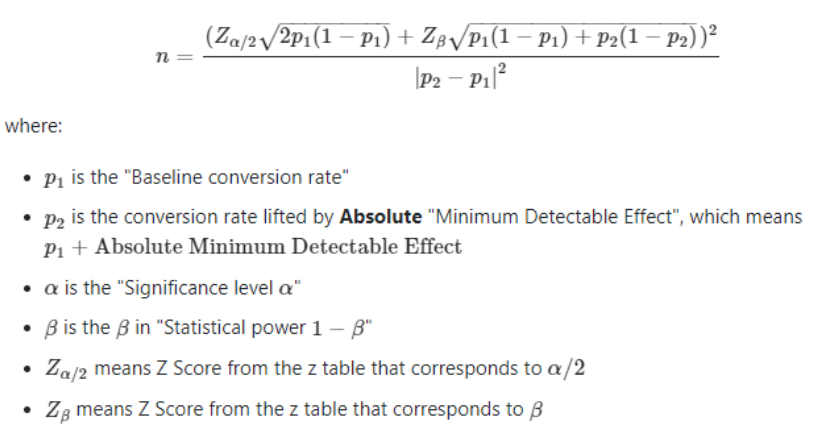

### Sample Size com Dados Históricos

In [2]:
import datetime
import numpy as np
import pandas as pd
import random
from scipy.optimize import bisect

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
observation_count = 20000
data = pd.DataFrame({'value': np.random.lognormal(size=observation_count)})

# Performance metric
def metric(x):
    return np.mean(x)

In [ ]:
data.head()

,value
0,0.282916
1,3.085240
2,0.437854
3,0.677162
4,3.094174


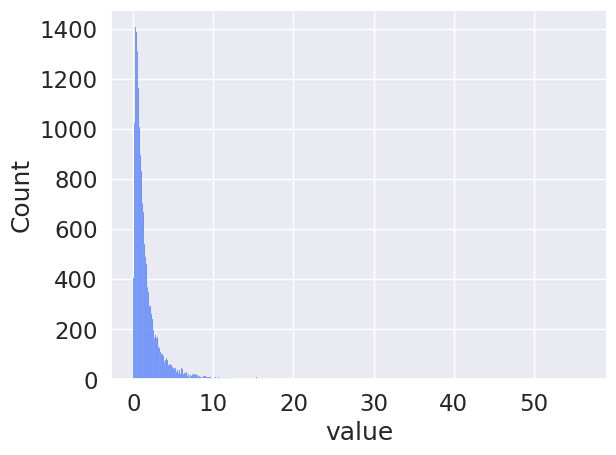

In [ ]:
sns.histplot(x = data['value']);

Definindo nossa significância $\alpha$, potência $1 - \beta$ e efeito mínimo detectável $\delta$

In [4]:
alpha = 0.05
beta = 0.2
delta = 0.1 * metric(data['value'])

Bootstrapping de Testes A/A

In [ ]:
def simulate(sample_size, bootstrap_rep):
    def run_one():
        return np.random.choice(data['value'], sample_size, replace=True)

    def run_many():
        return np.array([metric(run_one()) for _ in range(bootstrap_rep)])

    # Simulation under the null hypothesis
    control_null = run_many()
    treatment_null = run_many()
    difference_null = treatment_null - control_null

    # Simulation under the alternative hypothesis
    control_alternative = run_many()
    treatment_alternative = run_many() + delta
    difference_alternative = treatment_alternative - control_alternative

    # Computation of the critical value
    critical_value = np.quantile(difference_null, 1 - alpha)
    # Computation of the false-negative rate
    beta_simulated = np.mean(difference_alternative < critical_value)

    return {
        'difference_null': difference_null,
        'difference_alternative': difference_alternative,
        'critical_value': critical_value,
        'beta': beta_simulated
    }

In [ ]:
results = simulate(sample_size = 1000, bootstrap_rep = 1000)

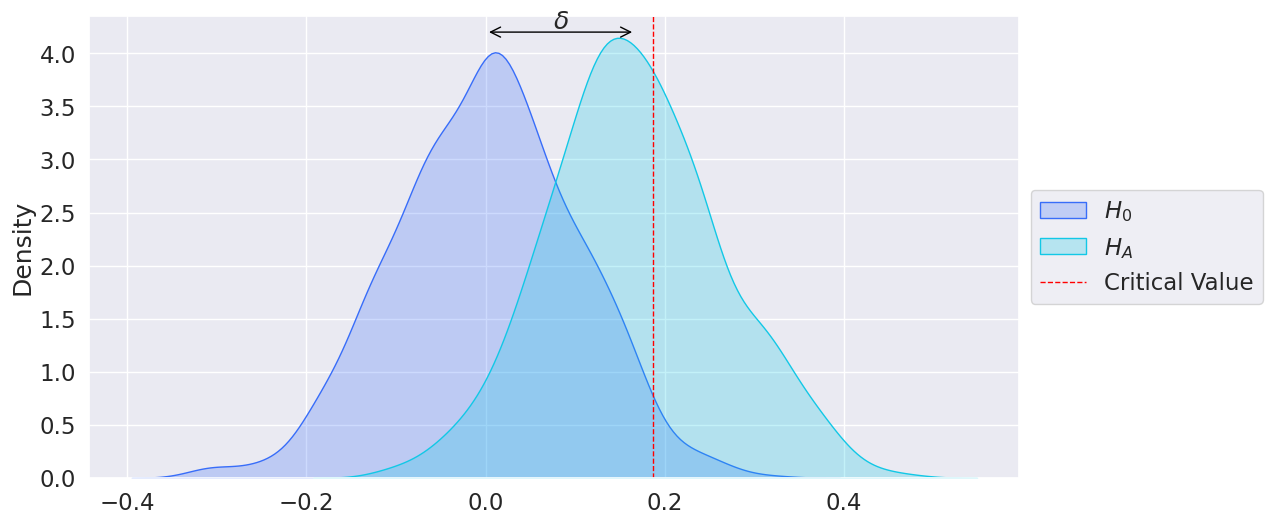

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
sns.kdeplot(x = results['difference_null'], fill = True, label = r"$H_0$", ax = ax);
sns.kdeplot(x = results['difference_alternative'], fill = True, label = r"$H_A$", ax = ax);

percentile_97_5 = np.percentile(results['difference_null'], 100 * (1 - alpha / 2.0))
plt.axvline(x=percentile_97_5, color='red', linestyle='--', linewidth = 1, label='Critical Value')


peak_null = results['difference_null'].mean()
peak_alternative = results['difference_alternative'].mean()

plt.annotate('', xy=(peak_alternative, 4.2), xytext=(peak_null, 4.2),
             arrowprops=dict(arrowstyle='<->', color='black'))

plt.text(x=(peak_null + peak_alternative) / 2, y=4.3, s=r'$\delta$',
         horizontalalignment='center', verticalalignment='center')


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));


Executado uma otimização para encontrar o resultado ótimo do nosso target de $\beta$

In [ ]:
bootstrap_rep = 1000
search_interval = (1, 10000)

# Root finding to attain the desired value by varying the sample size
def target(n):
    n = int(n)
    result = simulate(n, bootstrap_rep)
    return beta - result['beta']

sample_size = int(bisect(target, *search_interval))

O sample size necessário para o efeito de 10%, $\alpha = 0.05$ e $\beta = 0.2$ é:

In [ ]:
sample_size

2501

## Experimento 1

Uma plataforma de vídeos cuja principal fonte de receita é propaganda. Suponha que ganhamos R$1.5 a cada segundo de ad visto por um cliente.

A plataforma quer saber se deve aumentar a quantidade de ads.

In [5]:
# créditos ao Hector Lira

np.random.seed(200)
random.seed(200)

n_customers = 1000

customer_ids = []
experiment_groups = []
timestamps = []
videos_seen_logs = []
ads_time_logs = []
ages = []
genders = []

start_date = datetime.datetime(2021, 6, 1, 00, 00)

for i in range(n_customers):

  experiment_group = random.choices(["control", "variant"])[0]
  age = int(np.random.uniform(low=18, high=60))
  gender = random.choices(["m", "w"], weights = [0.5, 0.5])[0]

  n_events = int(np.random.uniform(low=1, high=30))
  timestamp_event = start_date

  for j in range(n_events):
    random_range = np.random.uniform(low=1, high=10)
    timestamp_event = timestamp_event + datetime.timedelta(days=random_range)

    if experiment_group == "control":
      if age <= 35:
        ads_time = np.random.uniform(low=5, high=10)
        videos_seen = np.random.uniform(low=3, high=7)
      elif 35 < age < 45:
        ads_time = np.random.uniform(low=5, high=10)
        videos_seen = np.random.uniform(low=2, high=6)
      else:
        ads_time = np.random.uniform(low=5, high=10)
        videos_seen = np.random.uniform(low=1, high=4)

    else:
      if age <= 35:
        ads_time = np.random.uniform(low=10, high=15)
        videos_seen = np.random.uniform(low=1, high=5)
      elif 35 < age <= 45:
        ads_time = np.random.uniform(low=10, high=15)
        videos_seen = np.random.uniform(low=2, high=5)
      else:
        ads_time = np.random.uniform(low=10, high=15)
        videos_seen = np.random.uniform(low=1, high=4)

    customer_ids.append(i + 1)
    experiment_groups.append(experiment_group)
    timestamps.append(timestamp_event.strftime("%d/%m/%y %H:%M"))
    videos_seen_logs.append(round(videos_seen))
    ads_time_logs.append(round(ads_time, 2))
    ages.append(age)
    genders.append(gender)


df_videos = pd.DataFrame(data={
  "customer_id": customer_ids,
  "experiment_group": experiment_groups,
  "timestamp": timestamps,
  "videos_seen": videos_seen_logs,
  "avg_ads_time": ads_time_logs,
  "gender": genders,
  "age": ages
})

In [6]:
df_videos.head()

,customer_id,experiment_group,timestamp,videos_seen,avg_ads_time,gender,age
0,1,control,07/06/21 08:23,3,7.14,m,57
1,1,control,08/06/21 09:00,4,6.79,m,57
2,1,control,13/06/21 11:31,4,9.91,m,57
3,1,control,23/06/21 08:30,2,9.62,m,57
4,1,control,01/07/21 23:15,3,5.61,m,57


#### Análise de Confiabilidade do Experimento

Vamos avaliar se os grupos (controle e tratamento) são similares em termos de importantes covariáveis. Neste exemplo, faremos com variável _gender_ utilizando o teste de qui-quadrado.

In [7]:
gender = df_videos.groupby(['experiment_group', 'gender'])['customer_id'].count().reset_index()
gender['customer_id'] =  gender['customer_id'] / gender.groupby(['experiment_group'])['customer_id'].transform('sum')
gender.sort_values('gender', inplace = True)

In [8]:
gender

,experiment_group,gender,customer_id
0,control,m,0.491298
2,variant,m,0.511618
1,control,w,0.508702
3,variant,w,0.488382


In [12]:
from scipy.stats import chi2_contingency
df_user = df_videos.drop_duplicates(subset = 'customer_id')
contingency_table = pd.crosstab(df_user['gender'], df_user['experiment_group'])
chi2_contingency(contingency_table)

Chi2ContingencyResult(statistic=1.5038730143205223, pvalue=0.22007639576444454, dof=1, expected_freq=array([[264.187, 246.813],
       [252.813, 236.187]]))

#### Análise dos Resultados do Experimento

Vamos calcular a principal métrica de interesse que é Receita, sendo

$$\text{Revenue} = \text{avg_ads_time} \times \text{videos_seen} \times 1.5 $$

Vamos avaliar os resultados via diferenças-em-médias e t-test.

In [ ]:
df_videos['revenue'] = df_videos['avg_ads_time'] * df_videos['videos_seen'] * 1.5

In [ ]:
df_videos.groupby('experiment_group')[['videos_seen', 'avg_ads_time', 'revenue']].mean()

,videos_seen,avg_ads_time,revenue
experiment_group,,,
control,4.023675,7.483262,45.152778
variant,2.952014,12.520630,55.445773


In [20]:
from scipy.stats import ttest_ind

In [ ]:
ttest_ind(df_videos.query('experiment_group == "variant"')['revenue'], df_videos.query('experiment_group == "control"')['revenue'])

Ttest_indResult(statistic=29.451866212890568, pvalue=2.0165420552207215e-185)

In [ ]:
df_videos.query('experiment_group == "variant"')['revenue'].mean() - df_videos.query('experiment_group == "control"')['revenue'].mean()

10.292995014342637

## Experimento 2

E-commerce. Queremos saber se uma alteração no site da empresa resultará em maiores vendas


In [13]:
#@title

##### NÃO MODIFICAR ESTE CÓDIGO

# créditos ao Hector Lira

np.random.seed(100)
random.seed(100)
experiment_launch = "2021-06-01"
n_customers = 10000

customer_ids = []
visit_ids = []
experiment_groups = []
dates = []
all_purchases = []
total_sales = []
ages = []
genders = []

start_date = datetime.datetime(2021, 1, 1, 00, 00)


def get_sale_simulation(age, control=True):

  purchase_modifier = (not control) * 1

  if age <= 35:
    purchases = round(np.random.uniform(low=1, high=5 + purchase_modifier), 0)
    avg_ticket = round(np.random.uniform(low=25, high=50), 2)
  elif 35 < age < 45:
    purchases = round(np.random.uniform(low=1, high=10 + purchase_modifier), 0)
    avg_ticket = round(np.random.uniform(low=30, high=60), 2)
  else:
    purchases = round(np.random.uniform(low=2, high=15 + purchase_modifier), 0)
    avg_ticket = round(np.random.uniform(low=30, high=60), 2)

  total_sale = round(purchases * avg_ticket, 2)

  return purchases, avg_ticket, total_sale


for i in range(n_customers):

  experiment_group = random.choices(["control", "variant"])[0]
  age = int(np.random.uniform(low=18, high=60))
  gender = random.choices(["m", "w"], weights = [0.5, 0.5])[0]

  n_events = int(np.random.uniform(low=1, high=15))

  for j in range(n_events):
    random_range = np.random.uniform(low=1, high=360)
    date_event = start_date + datetime.timedelta(days=random_range)

    if (
        date_event.strftime("%Y-%m-%d") < experiment_launch or
        experiment_group == "control"
    ):
        purchases, avg_ticket, total_sale = get_sale_simulation(age)
    else:
        purchases, avg_ticket, total_sale = get_sale_simulation(age, False)

    customer_ids.append(i + 1)
    experiment_groups.append(experiment_group)
    dates.append(date_event.strftime("%Y-%m-%d"))
    all_purchases.append(purchases)
    total_sales.append(total_sale)
    ages.append(age)
    genders.append(gender)


df_purchases = pd.DataFrame(data={
  "customer_id": customer_ids,
  "experiment_group": experiment_groups,
  "date": dates,
  "purchases": all_purchases,
  "total_sale": total_sales,
  "age": ages,
  "gender": genders,
}).sort_values(by=["customer_id", "date"])

df_purchases["date"] = pd.to_datetime(df_purchases["date"])

df_purchases["week"] = df_purchases["date"] - df_purchases["date"].dt.weekday * np.timedelta64(1, 'D')

In [14]:
df_purchases.head()

,customer_id,experiment_group,date,purchases,total_sale,age,gender,week
1,1,control,2021-02-14,7.0,383.46,40,m,2021-02-08
2,1,control,2021-02-20,6.0,340.44,40,m,2021-02-15
3,1,control,2021-03-18,3.0,99.75,40,m,2021-03-15
0,1,control,2021-06-03,9.0,271.26,40,m,2021-05-31
13,2,variant,2021-01-09,2.0,77.24,27,w,2021-01-04


### Análise de Confiabilidade do Experimento

Vamos verificar se os grupos são similares em idade


In [15]:
df_purchases[["customer_id", "age", "experiment_group"]].drop_duplicates().groupby("experiment_group").agg({
    "age": "mean",
    "customer_id": "count"
}).reset_index()

,experiment_group,age,customer_id
0,control,38.242328,5018
1,variant,38.427138,4982


In [21]:
df_age = df_purchases.drop_duplicates(subset = 'customer_id')
ttest_ind(df_age.query('experiment_group == "variant"')['age'], df_age.query('experiment_group == "control"')['age'])

TtestResult(statistic=0.7700673766005732, pvalue=0.44127812089245355, df=9998.0)

Vamos verificar se os grupos são similares em termos das métricas pré-experimentais

In [16]:
pre_experiment_data = df_purchases[df_purchases["date"] < experiment_launch]

pre_experiment_data.groupby("experiment_group").agg({
    "purchases": "mean",
    "total_sale": "mean"
}).reset_index()

,experiment_group,purchases,total_sale
0,control,5.432685,234.820988
1,variant,5.465428,236.935299


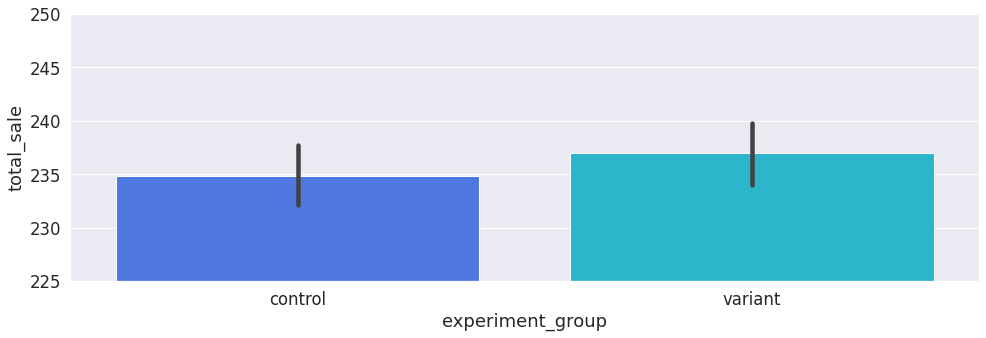

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(data=pre_experiment_data, y="total_sale", x="experiment_group", ax=ax)
ax.set_ylim(225, 250)

fig.tight_layout(pad=3.0)

In [ ]:
ttest_ind(pre_experiment_data.query('experiment_group == "variant"')['total_sale'], pre_experiment_data.query('experiment_group == "control"')['total_sale'])

Ttest_indResult(statistic=1.0555176337566787, pvalue=0.29119681324813596)

#### Análise dos Resultados do Experimento

In [ ]:
post_experiment_data = df_purchases[df_purchases["date"] >= experiment_launch]

post_experiment_data.groupby("experiment_group").agg({
    "purchases": "mean",
    "total_sale": "mean"
}).reset_index()

,experiment_group,purchases,total_sale
0,control,5.457336,235.902706
1,variant,5.978319,257.764180


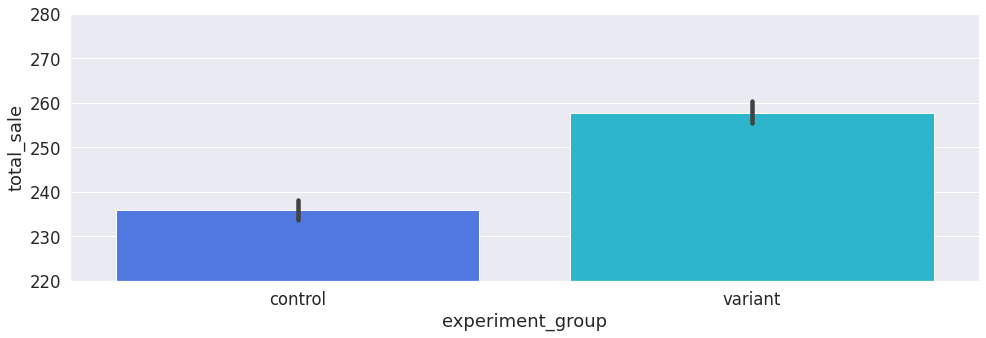

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(data=post_experiment_data, y="total_sale", x="experiment_group", ax=ax)
ax.set_ylim(220, 280)

fig.tight_layout(pad=3.0)

In [ ]:
ttest_ind(post_experiment_data.query('experiment_group == "variant"')['total_sale'], post_experiment_data.query('experiment_group == "control"')['total_sale'])

Ttest_indResult(statistic=12.51207902150214, pvalue=7.394440387498017e-36)

In [ ]:
post_experiment_data.query('experiment_group == "variant"')['total_sale'].mean() - post_experiment_data.query('experiment_group == "control"')['total_sale'].mean()

21.86147379725159

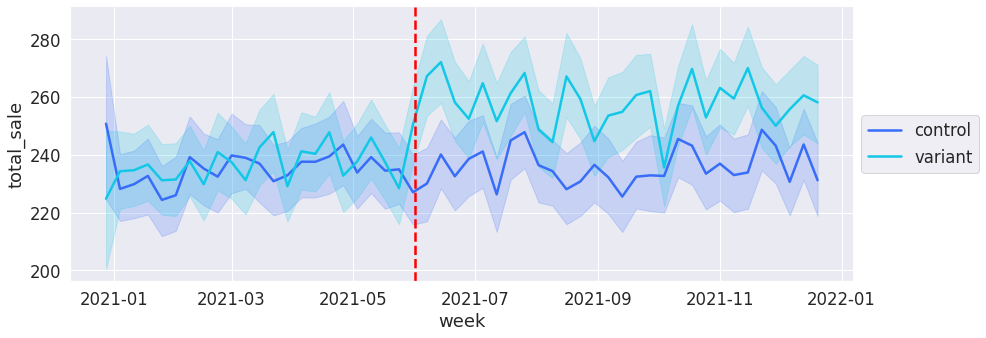

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(data=df_purchases, y="total_sale", x="week", hue="experiment_group",ax=ax)
ax.axvline(datetime.datetime(2021, 6, 1), color="red", ls="--")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
fig.tight_layout(pad=3.0)

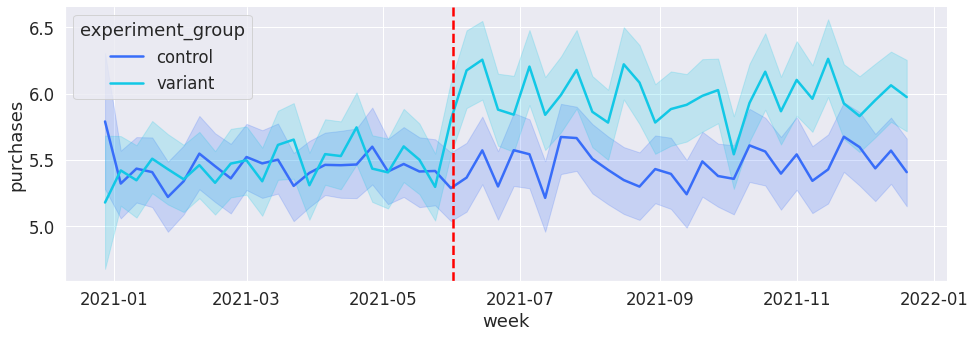

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(data=df_purchases, y="purchases", x="week", hue="experiment_group",ax=ax)
ax.axvline(datetime.datetime(2021, 6, 1), color="red", ls="--")
sns.despine()
fig.tight_layout(pad=3.0)

Avaliando o resultado semanalmente, vemos uma alta variância dos resultados. Por isso, é necessário avaliar essa dinâmica antes do experimento para decidir o quanto tempo de monitoramento é necessário para uma maior estabilidade.

Observação: na análise abaixo, não fazemos correções post hoc. Toda vez que fazemos múltiplos testes estatísticos em sequência, a taxa de falso positivos pode aumentar senão fizermos esse tipo de correção (ver Correção de Bonferroni para maiores informações)

In [ ]:
weeks = []
pvalues_sales = []
pvalues_volume = []
for week, df_week in df_purchases.groupby('week'):
  weeks.append(week)
  pvalues_sales.append(ttest_ind(df_week.query('experiment_group == "variant"')['total_sale'], df_week.query('experiment_group == "control"')['total_sale'])[-1])
  pvalues_volume.append(ttest_ind(df_week.query('experiment_group == "variant"')['purchases'], df_week.query('experiment_group == "control"')['purchases'])[-1])

pvalue_df = pd.DataFrame({'week' : weeks, 'p-values_sales' : pvalues_sales, 'p-values_volume' : pvalues_volume})

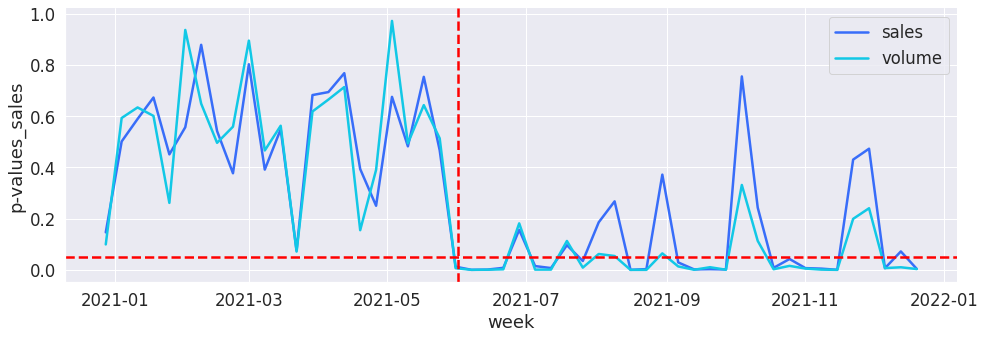

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(data=pvalue_df, y="p-values_sales", x="week", ax=ax, label = 'sales')
sns.lineplot(data=pvalue_df, y="p-values_volume", x="week", ax=ax, label = 'volume')
ax.axvline(datetime.datetime(2021, 6, 1), color="red", ls="--")
ax.axhline(0.05, color="red", ls="--")
plt.legend()
sns.despine()
fig.tight_layout(pad=3.0)

## Experimento 3


In [ ]:
from joblib import Parallel, delayed
from dataclasses import dataclass
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
@dataclass
class DGP:
    n: int = 100
    p: int = 0.5

    def __post_init__(self):
        self.df = self.generate_potential_outcomes()

    def generate_baseline(self, seed: int = 0) -> pd.DataFrame:
        """Generates a dataframes with the baseline outcome."""
        return pd.DataFrame()

    def add_treatment_effect(self, df : pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        """Add the treatment effect to the baseline outcome."""
        return pd.DataFrame

    def generate_potential_outcomes(self, seed: int = 0) -> pd.DataFrame:
        """Generates a dataframes with treatment and control potential outcomes."""
        df = self.generate_baseline(seed)
        df = self.add_treatment_effect(df, seed)
        for y in self.Y:
            df[y + '_t'] = df[y + '_c'] + df['effect_on_' + y]
            del df['effect_on_' + y]
        return df.round(2)

    def add_assignment(self, df: pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        """Adds the treatment assignment variable."""
        np.random.seed(seed)
        df[self.D] = np.random.binomial(1, self.p, self.n)
        return df

    def generate_data(self, seed_data: int = 0, seed_assignment: int = 1, **kwargs) -> pd.DataFrame:
        """Generate potential outcomes, add assignment and select realized outcomes."""
        df = self.generate_potential_outcomes(seed_data, **kwargs)
        df = self.add_assignment(df, seed_assignment)
        d = df[self.D].values
        for y in self.Y:
            df[y] = df[y + '_c'].values * (1-d) + df[y + '_t'].values * d
            del df[y + '_c']
            del df[y + '_t']
        return df

    def evaluate_f_redrawing_data(self, f, K):
        """Evaluates the function f on K draws of the data (both potential outcomes and treatment assignment)."""
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_data(seed_data=i, seed_assignment=K-i)) for i in range(K))
        return results

    def evaluate_f_redrawing_outcomes(self, f, K):
        """Evaluates the function f on K draws of the treatment assignment. Potential outcomes are fixed."""
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_data(seed_assignment=i)) for i in range(K))
        return results

    def evaluate_f_redrawing_potentialoutcomes(self, f, K):
        """Evaluates the function f on K draws of the potential outcomes."""
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_potential_outcomes(seed_data=i)) for i in range(K))
        return results

class dgp_infinite_scroll(DGP):
    D = 'infinite_scroll'
    Y  = ['ad_revenue']

    def generate_potential_outcomes(self, seed: int = 0, true_effect: float = None):
        np.random.seed(seed)
        past = np.random.normal(2, 1, self.n)
        outcome_c = np.random.normal(past, 1, self.n)
        avg_effect = np.random.standard_t(1.3) / 300 if true_effect is None else true_effect
        outcome_t = outcome_c + avg_effect
        df = pd.DataFrame({'ad_revenue_c': outcome_c, 'ad_revenue_t': outcome_t, 'past_revenue': past})
        return df.round(2)


In [ ]:
dgp = dgp_infinite_scroll(n=10_000)
df = dgp.generate_data(true_effect=0.14)
df.head()

,past_revenue,infinite_scroll,ad_revenue
0,3.76,0,3.56
1,2.40,1,1.71
2,2.98,0,4.71
3,4.24,0,4.43
4,3.87,0,3.69


In [ ]:
result = df.groupby("infinite_scroll")['ad_revenue'].mean()
result

infinite_scroll
0    1.990553
1    2.134619
Name: ad_revenue, dtype: float64

Nos experimentos anteriores, avaliamos os resultados fazendo uma diferença em médias por grupo e avaliando a significância utilizando o t-test. Neste exemplo, vamos demonstrar que é possível também analisar os resultados de um experimento via Regressão Linear.

Neste caso, vamos modelar uma regressão linear em que temos:

$$ y = w_0 + w_1 X$$

Neste exemplo, $y$ é a métrica de interesse, ou seja, _ad_revenue_ e $X$ é o nosso tratamento _infinite_scroll_. $w_0$ e $w_1$ são os pesos (parâmetros) da regressão linear estimados via processo de treino executado abaixo com o método _fit(.)_.

Ao final da regressão, podemos interpretar $w_1$ como o efeito do tratamento. Veja que o valor é muito próximo do calculado via diferença em médias. Pela regressão, obtemos também a significância (p-valor) e o intervalo de confiança do efeito. Isso poderia ser obtido também via t-test e bootstrapping.

In [ ]:
result[1] - result[0] # diferença em médias

0.14406565626262502

In [ ]:
smf.ols('ad_revenue ~ infinite_scroll', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.9906,0.020,100.783,0.000,1.952,2.029
infinite_scroll,0.1441,0.028,5.163,0.000,0.089,0.199


**Redução de Variância utilizando variáveis pré-experimento. Ver CUPED**

In [ ]:
reg = smf.ols('ad_revenue ~ infinite_scroll + past_revenue', df).fit()
reg.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0170,0.024,0.696,0.487,-0.031,0.065
infinite_scroll,0.1588,0.020,7.992,0.000,0.120,0.198
past_revenue,0.9923,0.010,98.659,0.000,0.973,1.012
